In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define the path to the folders
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork'
folders = ['DNA_BERT2', 'HyenaDNA', 'mistral','nucleotide-transformer-500m-human-ref']

In [3]:
# Dictionary to store matrices
matrices = {}

# Read and store matrices
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for file_name in os.listdir(folder_path):
        print(file_name)
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            if folder == 'nucleotide-transformer-500m-human-ref':
                emb_file =  np.load(file_path)
                matrices[file_name] = np.matrix(emb_file) 
            else:
                emb_file =  np.load(file_path,allow_pickle=True)
                matrices[file_name] = np.vstack(np.array(emb_file))
           

In [5]:
def calculate_column_wise_correlation(matrix):
    """Calculate column-wise correlation for the given matrix using NumPy."""
    # Calculate the correlation matrix
    correlation_matrix = np.corrcoef(matrix, rowvar=False)
    return correlation_matrix

def flatten_correlation_matrix(correlation_matrix):
    """Flatten the correlation matrix into a vector of correlation values."""
    # Get the upper triangle of the correlation matrix, excluding the diagonal
    triu_indices = np.triu_indices_from(correlation_matrix, k=1)
    flattened_vector = correlation_matrix[triu_indices]
    return flattened_vector

# DB2

demo_coding_vs_intergenomic - Embeddings shape: (100000, 768), Labels length: 100000
human_enhancers_cohn - Embeddings shape: (27791, 768), Labels length: 27791
human_enhancers_ensembl - Embeddings shape: (154842, 768), Labels length: 154842
human_nontata_promoters - Embeddings shape: (36131, 768), Labels length: 36131


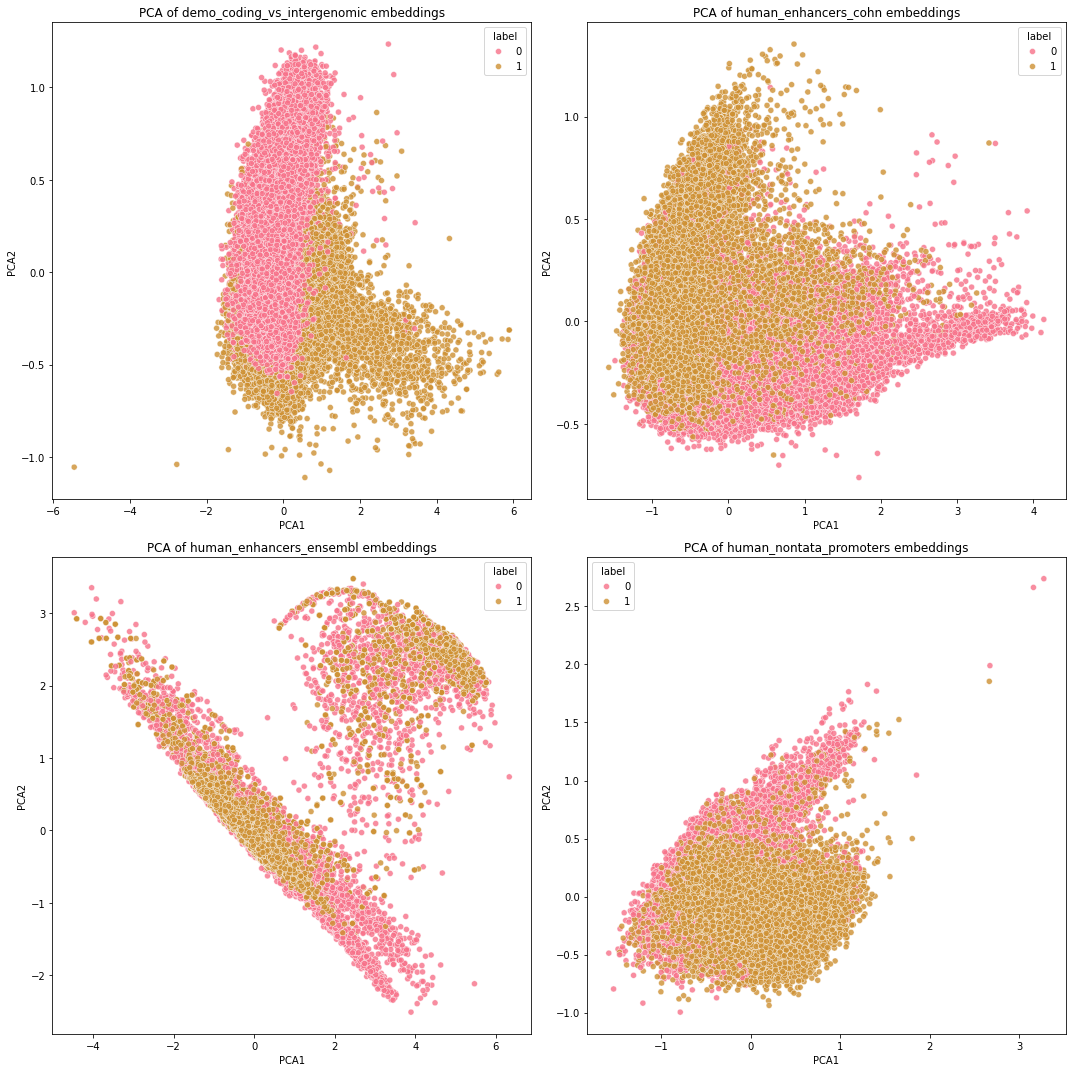

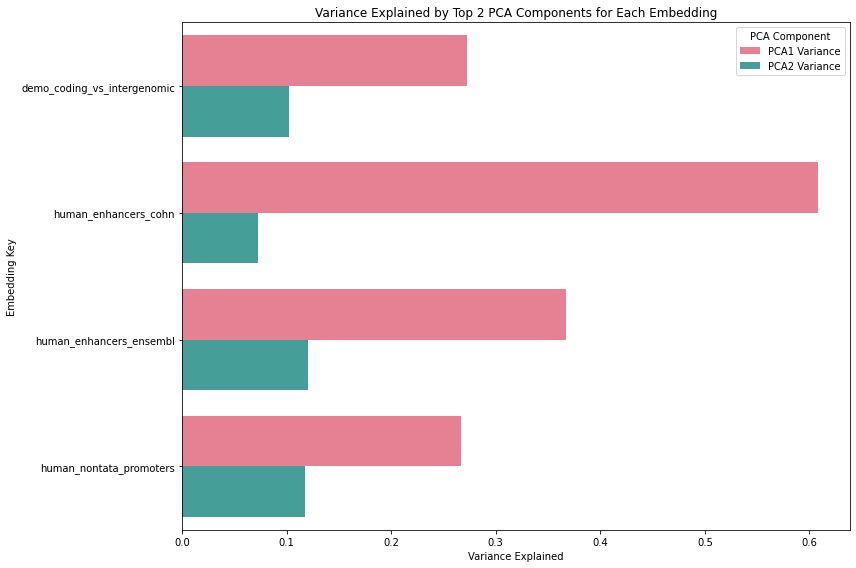

Total Variance Explained by Top 2 PCA Components:
                           Key  Total Variance (Top 2 PCA)
0  demo_coding_vs_intergenomic                    0.375230
1         human_enhancers_cohn                    0.680209
2      human_enhancers_ensembl                    0.487421
3      human_nontata_promoters                    0.384224


In [6]:
%matplotlib inline


# Function to combine train and test matrices
def combine_train_test(train_file, test_file):
    train_matrix = matrices[train_file]
    test_matrix = matrices[test_file]
    combined_matrix = np.vstack((train_matrix, test_matrix))
    return combined_matrix

# Combine the matrices for each sequence type
combined_matrices = {}
combined_matrices['demo_coding_vs_intergenomic'] = combine_train_test(
    'train_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy', 
    'test_demo_coding_vs_intergenomic_seqs_DB2_Embeddings.npy'
)
combined_matrices['human_enhancers_cohn'] = combine_train_test(
    'train_human_enhancers_cohn_DB2_Embeddings.npy', 
    'test_human_enhancers_cohn_DB2_Embeddings.npy'
)
combined_matrices['human_enhancers_ensembl'] = combine_train_test(
    'train_human_enhancers_ensembl_DB2_Embeddings.npy', 
    'test_human_enhancers_ensembl_DB2_Embeddings.npy'
)

combined_matrices['human_nontata_promoters'] = combine_train_test(
    'train_human_nontata_promoters_DB2_Embeddings.npy', 
    'test_human_nontata_promoters_DB2_Embeddings.npy'
)


# Paths to CSV files
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/'

csv_files = {
    'demo_coding_vs_intergenomic': ['train_demo_coding_vs_intergenomic_seqs.csv', 'test_demo_coding_vs_intergenomic_seqs.csv'],
    'human_enhancers_cohn': ['train_human_enhancers_cohn.csv', 'test_human_enhancers_cohn.csv'],
    'human_enhancers_ensembl': ['train_human_enhancers_ensembl.csv', 'test_human_enhancers_ensembl.csv'],
    'human_nontata_promoters': ['train_human_nontata_promoters.csv', 'test_human_nontata_promoters.csv'],
}

# Dictionary to store combined DataFrames
combined_dfs = {}

# Function to combine train and test DataFrames
def combine_train_test(train_file, test_file):
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return combined_df

# Combine the DataFrames for each sequence type
for key, (train_file, test_file) in csv_files.items():
    train_path = os.path.join(base_path, train_file)
    test_path = os.path.join(base_path, test_file)
    combined_dfs[key] = combine_train_test(train_path, test_path)



# Set the color palette for all plots
sns.set_palette(sns.color_palette("husl", 8))

# Assuming `combined_matrices` and `combined_dfs` are predefined

# Create a 2-column, 2-row grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (key, embeddings) in enumerate(combined_matrices.items()):
    # Check if the dimensions of the embeddings and the labels match
    print(f"{key} - Embeddings shape: {embeddings.shape}, Labels length: {len(combined_dfs[key])}")

    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    
    # Merge with the labels
    combined_df = combined_dfs[key]
    pca_df['label'] = combined_df['label']
    
    # Create a scatter plot on the respective axis
    sns.scatterplot(
        x='PCA1', y='PCA2',
        hue='label',
        data=pca_df,
        legend="full",
        alpha=0.8,
        ax=axes[i]
    )
    
    axes[i].set_title(f'PCA of {key} embeddings')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')

# Adjust layout
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_scatter_plots_DB2.pdf')
plt.show()

# Prepare data for bar plot
variance_data = []

for key, embeddings in combined_matrices.items():
    # Check if the dimensions of the embeddings and the labels match
    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Calculate the variance explained by the top 2 PCA components
    explained_variance_ratio = pca.explained_variance_ratio_
    variance_data.append({
        'Key': key,
        'PCA1 Variance': explained_variance_ratio[0],
        'PCA2 Variance': explained_variance_ratio[1],
        'Total Variance (Top 2 PCA)': explained_variance_ratio[0] + explained_variance_ratio[1]
    })
    
# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)

# Melt the DataFrame for easier plotting with seaborn
variance_melted = variance_df.melt(id_vars=['Key'], value_vars=['PCA1 Variance', 'PCA2 Variance'],
                                    var_name='PCA Component', value_name='Variance Explained')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Variance Explained', y='Key', hue='PCA Component', data=variance_melted, palette='husl')
plt.title('Variance Explained by Top 2 PCA Components for Each Embedding')
plt.xlabel('Variance Explained')
plt.ylabel('Embedding Key')
plt.legend(title='PCA Component')
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_variance_bar_plot_DB2.pdf')
plt.show()

# Print the total variance explained by the top 2 components
print("Total Variance Explained by Top 2 PCA Components:")
print(variance_df[['Key', 'Total Variance (Top 2 PCA)']])

Processing demo_coding_vs_intergenomic...
Mean of demo_coding_vs_intergenomic correlation values: -0.0010
Standard Deviation of demo_coding_vs_intergenomic correlation values: 0.1126
Processing human_enhancers_cohn...
Mean of human_enhancers_cohn correlation values: -0.0005
Standard Deviation of human_enhancers_cohn correlation values: 0.1822
Processing human_enhancers_ensembl...
Mean of human_enhancers_ensembl correlation values: -0.0010
Standard Deviation of human_enhancers_ensembl correlation values: 0.2087
Processing human_nontata_promoters...
Mean of human_nontata_promoters correlation values: -0.0012
Standard Deviation of human_nontata_promoters correlation values: 0.1543


/tmp/job.1712284.hpc/ipykernel_56959/4217531663.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)


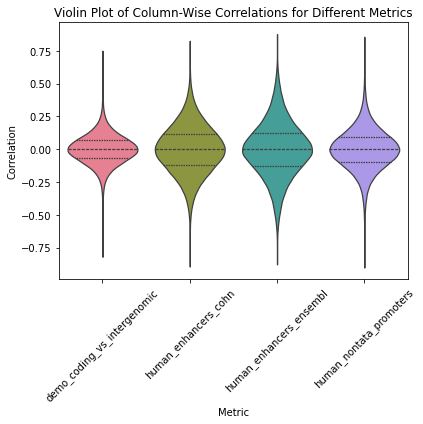

In [7]:
# Flatten the correlation matrices and organize into a DataFrame
data_for_violin_plot = []
for key, matrix in combined_matrices.items():
    print(f"Processing {key}...")
    correlation_matrix = calculate_column_wise_correlation(matrix)
    flattened_vector = flatten_correlation_matrix(correlation_matrix)
    
    # Calculate mean and standard deviation
    mean_value = np.mean(flattened_vector)
    std_dev_value = np.std(flattened_vector)
    
    # Print the mean and standard deviation
    print(f"Mean of {key} correlation values: {mean_value:.4f}")
    print(f"Standard Deviation of {key} correlation values: {std_dev_value:.4f}")
    
    # Append the correlation values to the list
    for value in flattened_vector:
        data_for_violin_plot.append({'Metric': key, 'Correlation': value})

# Convert list to DataFrame
df_for_violin_plot = pd.DataFrame(data_for_violin_plot)

# Define a color palette for the violin plot
# This example uses a color palette with a different color for each metric
palette = sns.color_palette("husl", len(df_for_violin_plot['Metric'].unique()))

# Create the violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)
plt.title('Violin Plot of Column-Wise Correlations for Different Metrics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/Correlation_Violen_plot_DB2.pdf')
plt.show()

# HD

demo_coding_vs_intergenomic - Embeddings shape: (100000, 256), Labels length: 100000
human_enhancers_cohn - Embeddings shape: (27791, 256), Labels length: 27791
human_enhancers_ensembl - Embeddings shape: (154842, 256), Labels length: 154842
human_nontata_promoters - Embeddings shape: (36131, 256), Labels length: 36131


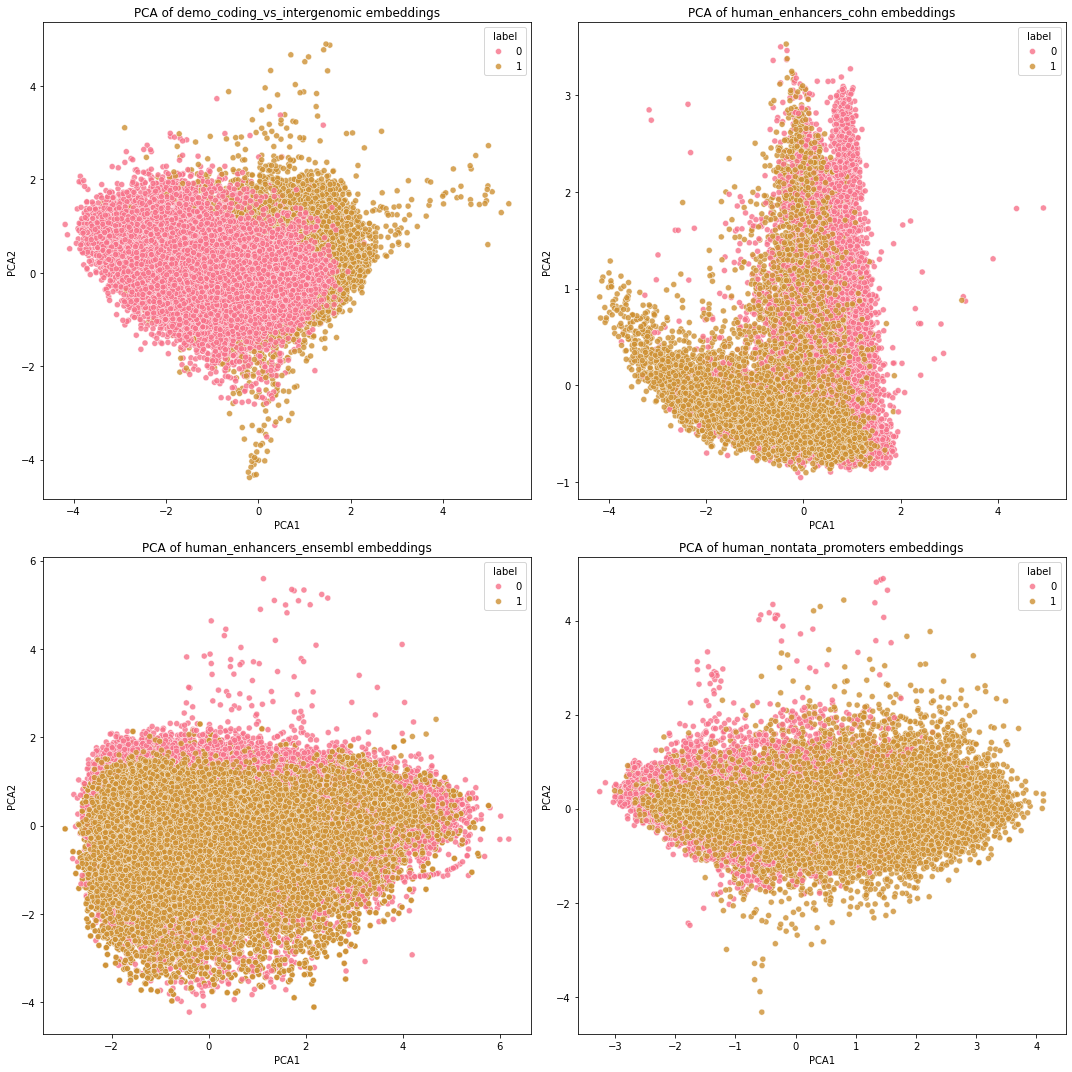

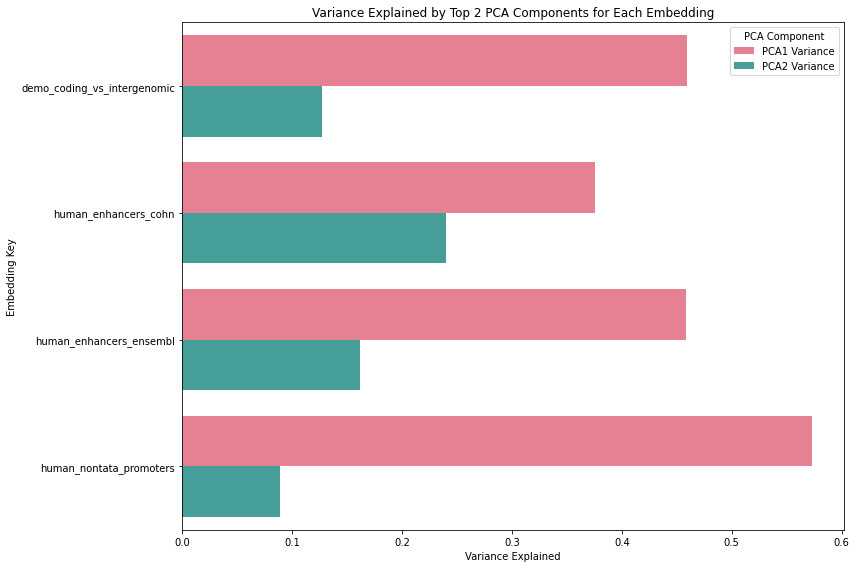

Total Variance Explained by Top 2 PCA Components:
                           Key  Total Variance (Top 2 PCA)
0  demo_coding_vs_intergenomic                    0.586506
1         human_enhancers_cohn                    0.615818
2      human_enhancers_ensembl                    0.620493
3      human_nontata_promoters                    0.662481


In [8]:
%matplotlib inline


# Function to combine train and test matrices
def combine_train_test(train_file, test_file):
    train_matrix = matrices[train_file]
    test_matrix = matrices[test_file]
    combined_matrix = np.vstack((train_matrix, test_matrix))
    return combined_matrix

# Combine the matrices for each sequence type
combined_matrices = {}
combined_matrices['demo_coding_vs_intergenomic'] = combine_train_test(
    'train_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy', 
    'test_demo_coding_vs_intergenomic_seqs_HD_Embeddings.npy'
)
combined_matrices['human_enhancers_cohn'] = combine_train_test(
    'train_human_enhancers_cohn_HD_Embeddings.npy', 
    'test_human_enhancers_cohn_HD_Embeddings.npy'
)
combined_matrices['human_enhancers_ensembl'] = combine_train_test(
    'train_human_enhancers_ensembl_HD_Embeddings.npy', 
    'test_human_enhancers_ensembl_HD_Embeddings.npy'
)

combined_matrices['human_nontata_promoters'] = combine_train_test(
    'train_human_nontata_promoters_HD_Embeddings.npy', 
    'test_human_nontata_promoters_HD_Embeddings.npy'
)


# Paths to CSV files
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/'

csv_files = {
    'demo_coding_vs_intergenomic': ['train_demo_coding_vs_intergenomic_seqs.csv', 'test_demo_coding_vs_intergenomic_seqs.csv'],
    'human_enhancers_cohn': ['train_human_enhancers_cohn.csv', 'test_human_enhancers_cohn.csv'],
    'human_enhancers_ensembl': ['train_human_enhancers_ensembl.csv', 'test_human_enhancers_ensembl.csv'],
    'human_nontata_promoters': ['train_human_nontata_promoters.csv', 'test_human_nontata_promoters.csv'],
}

# Dictionary to store combined DataFrames
combined_dfs = {}

# Function to combine train and test DataFrames
def combine_train_test(train_file, test_file):
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return combined_df

# Combine the DataFrames for each sequence type
for key, (train_file, test_file) in csv_files.items():
    train_path = os.path.join(base_path, train_file)
    test_path = os.path.join(base_path, test_file)
    combined_dfs[key] = combine_train_test(train_path, test_path)



# Set the color palette for all plots
sns.set_palette(sns.color_palette("husl", 8))

# Assuming `combined_matrices` and `combined_dfs` are predefined

# Create a 2-column, 2-row grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (key, embeddings) in enumerate(combined_matrices.items()):
    # Check if the dimensions of the embeddings and the labels match
    print(f"{key} - Embeddings shape: {embeddings.shape}, Labels length: {len(combined_dfs[key])}")

    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    
    # Merge with the labels
    combined_df = combined_dfs[key]
    pca_df['label'] = combined_df['label']
    
    # Create a scatter plot on the respective axis
    sns.scatterplot(
        x='PCA1', y='PCA2',
        hue='label',
        data=pca_df,
        legend="full",
        alpha=0.8,
        ax=axes[i]
    )
    
    axes[i].set_title(f'PCA of {key} embeddings')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')

# Adjust layout
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_scatter_plots_HD.pdf')

plt.show()

# Prepare data for bar plot
variance_data = []

for key, embeddings in combined_matrices.items():
    # Check if the dimensions of the embeddings and the labels match
    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Calculate the variance explained by the top 2 PCA components
    explained_variance_ratio = pca.explained_variance_ratio_
    variance_data.append({
        'Key': key,
        'PCA1 Variance': explained_variance_ratio[0],
        'PCA2 Variance': explained_variance_ratio[1],
        'Total Variance (Top 2 PCA)': explained_variance_ratio[0] + explained_variance_ratio[1]
    })
    
# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)

# Melt the DataFrame for easier plotting with seaborn
variance_melted = variance_df.melt(id_vars=['Key'], value_vars=['PCA1 Variance', 'PCA2 Variance'],
                                    var_name='PCA Component', value_name='Variance Explained')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Variance Explained', y='Key', hue='PCA Component', data=variance_melted, palette='husl')
plt.title('Variance Explained by Top 2 PCA Components for Each Embedding')
plt.xlabel('Variance Explained')
plt.ylabel('Embedding Key')
plt.legend(title='PCA Component')
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_variance_bar_plot_HD.pdf')
plt.show()

# Print the total variance explained by the top 2 components
print("Total Variance Explained by Top 2 PCA Components:")
print(variance_df[['Key', 'Total Variance (Top 2 PCA)']])

Processing demo_coding_vs_intergenomic...
Mean of demo_coding_vs_intergenomic correlation values: -0.0036
Standard Deviation of demo_coding_vs_intergenomic correlation values: 0.3778
Processing human_enhancers_cohn...
Mean of human_enhancers_cohn correlation values: -0.0035
Standard Deviation of human_enhancers_cohn correlation values: 0.3710
Processing human_enhancers_ensembl...
Mean of human_enhancers_ensembl correlation values: -0.0038
Standard Deviation of human_enhancers_ensembl correlation values: 0.3655
Processing human_nontata_promoters...
Mean of human_nontata_promoters correlation values: -0.0036
Standard Deviation of human_nontata_promoters correlation values: 0.4414


/tmp/job.1712284.hpc/ipykernel_56959/3325435196.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)


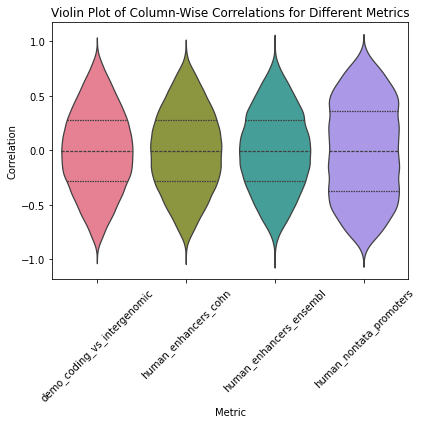

In [9]:
data_for_violin_plot = []
for key, matrix in combined_matrices.items():
    print(f"Processing {key}...")
    correlation_matrix = calculate_column_wise_correlation(matrix)
    flattened_vector = flatten_correlation_matrix(correlation_matrix)
    
    # Calculate mean and standard deviation
    mean_value = np.mean(flattened_vector)
    std_dev_value = np.std(flattened_vector)
    
    # Print the mean and standard deviation
    print(f"Mean of {key} correlation values: {mean_value:.4f}")
    print(f"Standard Deviation of {key} correlation values: {std_dev_value:.4f}")
    
    # Append the correlation values to the list
    for value in flattened_vector:
        data_for_violin_plot.append({'Metric': key, 'Correlation': value})

# Convert list to DataFrame
df_for_violin_plot = pd.DataFrame(data_for_violin_plot)

# Define a color palette for the violin plot
# This example uses a color palette with a different color for each metric
palette = sns.color_palette("husl", len(df_for_violin_plot['Metric'].unique()))

# Create the violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)
plt.title('Violin Plot of Column-Wise Correlations for Different Metrics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/Correlation_Violen_plot_HD.pdf')
plt.show()


# Mistral

demo_coding_vs_intergenomic - Embeddings shape: (100000, 256), Labels length: 100000
human_enhancers_cohn - Embeddings shape: (27791, 256), Labels length: 27791
human_enhancers_ensembl - Embeddings shape: (154842, 256), Labels length: 154842
human_nontata_promoters - Embeddings shape: (36131, 256), Labels length: 36131


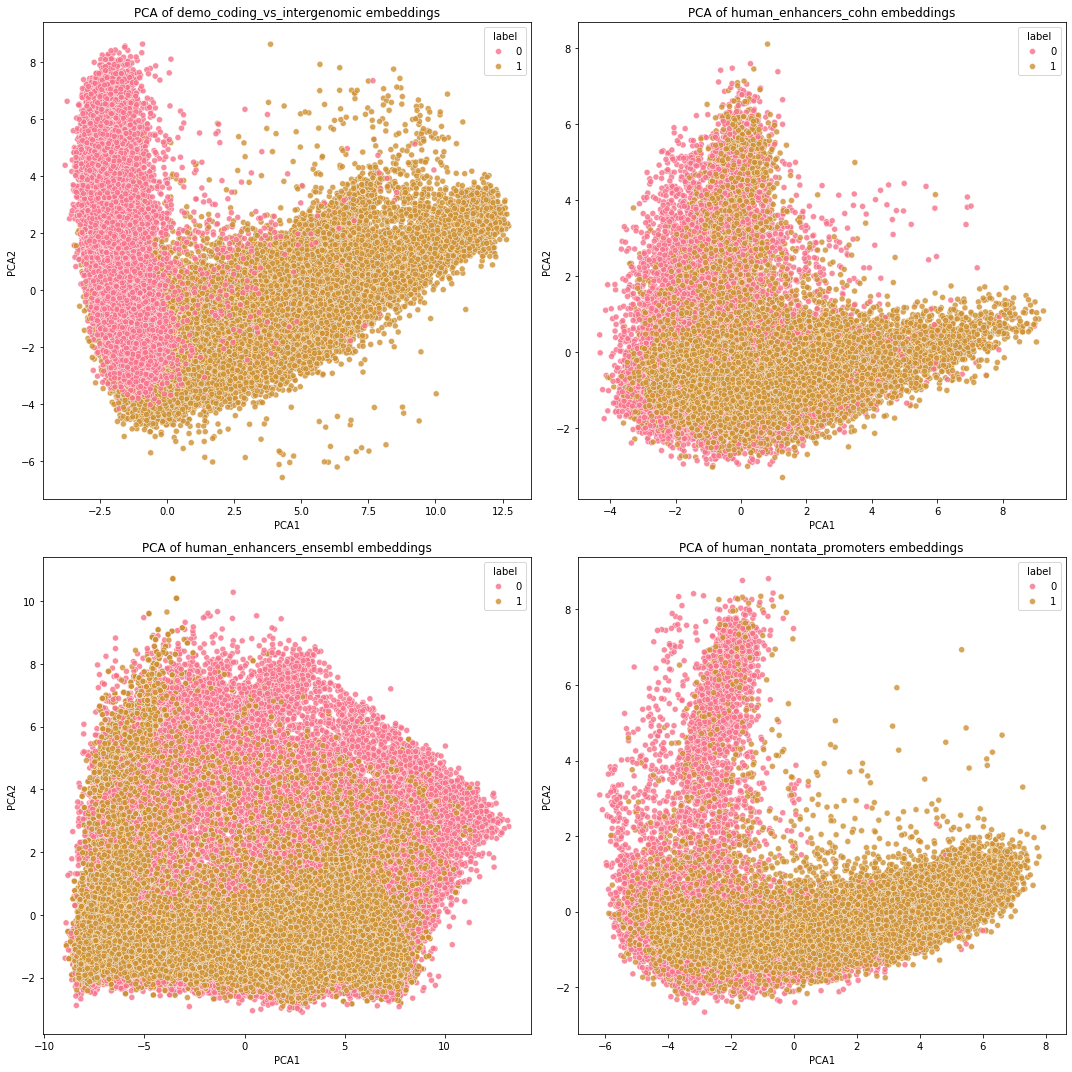

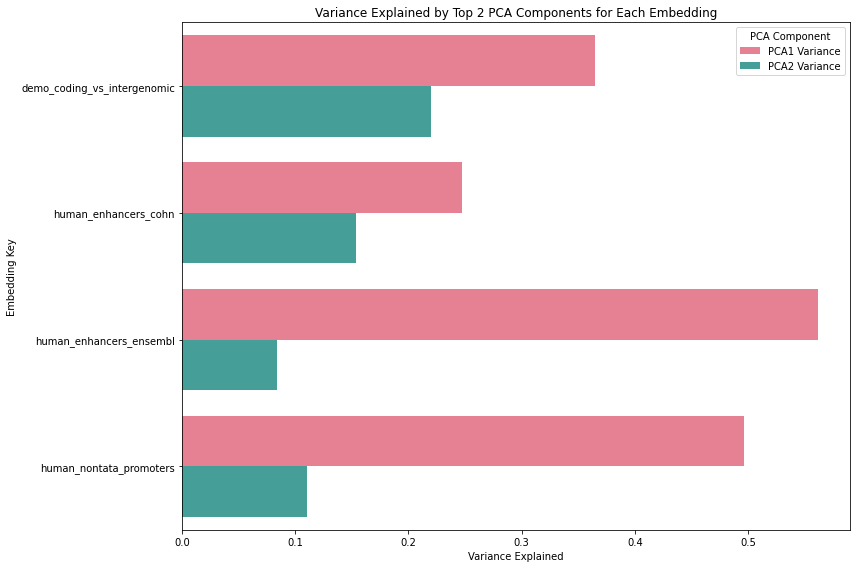

Total Variance Explained by Top 2 PCA Components:
                           Key  Total Variance (Top 2 PCA)
0  demo_coding_vs_intergenomic                    0.585028
1         human_enhancers_cohn                    0.401008
2      human_enhancers_ensembl                    0.645059
3      human_nontata_promoters                    0.606694


In [10]:
%matplotlib inline

# Function to combine train and test matrices
def combine_train_test(train_file, test_file):
    train_matrix = matrices[train_file]
    test_matrix = matrices[test_file]
    combined_matrix = np.vstack((train_matrix, test_matrix))
    return combined_matrix

# Combine the matrices for each sequence type
combined_matrices = {}
combined_matrices['demo_coding_vs_intergenomic'] = combine_train_test(
    'train_demo_coding_vs_intergenomic_seqs_mistral_Embeddings.npy', 
    'test_demo_coding_vs_intergenomic_seqs_mistral_Embeddings.npy'
)
combined_matrices['human_enhancers_cohn'] = combine_train_test(
    'train_human_enhancers_cohn_mistral_Embeddings.npy', 
    'test_human_enhancers_cohn_mistral_Embeddings.npy'
)
combined_matrices['human_enhancers_ensembl'] = combine_train_test(
    'train_human_enhancers_ensembl_mistral_Embeddings.npy', 
    'test_human_enhancers_ensembl_mistral_Embeddings.npy'
)

combined_matrices['human_nontata_promoters'] = combine_train_test(
    'train_human_nontata_promoters_mistral_Embeddings.npy', 
    'test_human_nontata_promoters_mistral_Embeddings.npy'
)


# Paths to CSV files
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/'

csv_files = {
    'demo_coding_vs_intergenomic': ['train_demo_coding_vs_intergenomic_seqs.csv', 'test_demo_coding_vs_intergenomic_seqs.csv'],
    'human_enhancers_cohn': ['train_human_enhancers_cohn.csv', 'test_human_enhancers_cohn.csv'],
    'human_enhancers_ensembl': ['train_human_enhancers_ensembl.csv', 'test_human_enhancers_ensembl.csv'],
    'human_nontata_promoters': ['train_human_nontata_promoters.csv', 'test_human_nontata_promoters.csv'],
}

# Dictionary to store combined DataFrames
combined_dfs = {}

# Function to combine train and test DataFrames
def combine_train_test(train_file, test_file):
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return combined_df

# Combine the DataFrames for each sequence type
for key, (train_file, test_file) in csv_files.items():
    train_path = os.path.join(base_path, train_file)
    test_path = os.path.join(base_path, test_file)
    combined_dfs[key] = combine_train_test(train_path, test_path)



# Set the color palette for all plots
sns.set_palette(sns.color_palette("husl", 8))

# Assuming `combined_matrices` and `combined_dfs` are predefined

# Create a 2-column, 2-row grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (key, embeddings) in enumerate(combined_matrices.items()):
    # Check if the dimensions of the embeddings and the labels match
    print(f"{key} - Embeddings shape: {embeddings.shape}, Labels length: {len(combined_dfs[key])}")

    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    
    # Merge with the labels
    combined_df = combined_dfs[key]
    pca_df['label'] = combined_df['label']
    
    # Create a scatter plot on the respective axis
    sns.scatterplot(
        x='PCA1', y='PCA2',
        hue='label',
        data=pca_df,
        legend="full",
        alpha=0.8,
        ax=axes[i]
    )
    
    axes[i].set_title(f'PCA of {key} embeddings')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')

# Adjust layout
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_scatter_plots_mistral.pdf')
plt.show()

# Prepare data for bar plot
variance_data = []

for key, embeddings in combined_matrices.items():
    # Check if the dimensions of the embeddings and the labels match
    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)
    
    # Calculate the variance explained by the top 2 PCA components
    explained_variance_ratio = pca.explained_variance_ratio_
    variance_data.append({
        'Key': key,
        'PCA1 Variance': explained_variance_ratio[0],
        'PCA2 Variance': explained_variance_ratio[1],
        'Total Variance (Top 2 PCA)': explained_variance_ratio[0] + explained_variance_ratio[1]
    })
    
# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)

# Melt the DataFrame for easier plotting with seaborn
variance_melted = variance_df.melt(id_vars=['Key'], value_vars=['PCA1 Variance', 'PCA2 Variance'],
                                    var_name='PCA Component', value_name='Variance Explained')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Variance Explained', y='Key', hue='PCA Component', data=variance_melted, palette='husl')
plt.title('Variance Explained by Top 2 PCA Components for Each Embedding')
plt.xlabel('Variance Explained')
plt.ylabel('Embedding Key')
plt.legend(title='PCA Component')
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_variance_bar_plot_mistral.pdf')
plt.show()

# Print the total variance explained by the top 2 components
print("Total Variance Explained by Top 2 PCA Components:")
print(variance_df[['Key', 'Total Variance (Top 2 PCA)']])


Processing demo_coding_vs_intergenomic...
Mean of demo_coding_vs_intergenomic correlation values: 0.0028
Standard Deviation of demo_coding_vs_intergenomic correlation values: 0.3353
Processing human_enhancers_cohn...
Mean of human_enhancers_cohn correlation values: 0.0008
Standard Deviation of human_enhancers_cohn correlation values: 0.2558
Processing human_enhancers_ensembl...
Mean of human_enhancers_ensembl correlation values: 0.0109
Standard Deviation of human_enhancers_ensembl correlation values: 0.4190
Processing human_nontata_promoters...
Mean of human_nontata_promoters correlation values: 0.0010
Standard Deviation of human_nontata_promoters correlation values: 0.3591


/tmp/job.1712284.hpc/ipykernel_56959/4181276557.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)


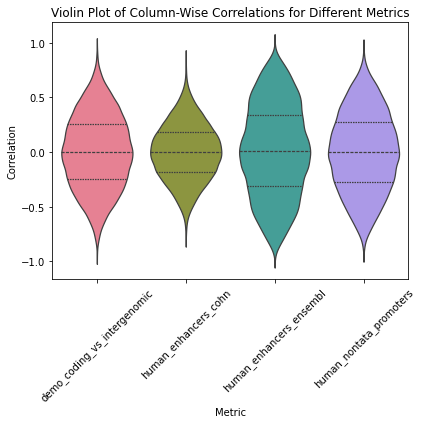

In [11]:

data_for_violin_plot = []
for key, matrix in combined_matrices.items():
    print(f"Processing {key}...")
    correlation_matrix = calculate_column_wise_correlation(matrix)
    flattened_vector = flatten_correlation_matrix(correlation_matrix)
    
    # Calculate mean and standard deviation
    mean_value = np.mean(flattened_vector)
    std_dev_value = np.std(flattened_vector)
    
    # Print the mean and standard deviation
    print(f"Mean of {key} correlation values: {mean_value:.4f}")
    print(f"Standard Deviation of {key} correlation values: {std_dev_value:.4f}")
    
    # Append the correlation values to the list
    for value in flattened_vector:
        data_for_violin_plot.append({'Metric': key, 'Correlation': value})

# Convert list to DataFrame
df_for_violin_plot = pd.DataFrame(data_for_violin_plot)

# Define a color palette for the violin plot
# This example uses a color palette with a different color for each metric
palette = sns.color_palette("husl", len(df_for_violin_plot['Metric'].unique()))

# Create the violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)
plt.title('Violin Plot of Column-Wise Correlations for Different Metrics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/Correlation_Violen_plot_mistral.pdf')
plt.show()


# NT

demo_coding_vs_intergenomic - Embeddings shape: (100000, 1280), Labels length: 100000
human_enhancers_cohn - Embeddings shape: (27791, 1280), Labels length: 27791
human_enhancers_ensembl - Embeddings shape: (154842, 1280), Labels length: 154842
human_nontata_promoters - Embeddings shape: (36131, 1280), Labels length: 36131


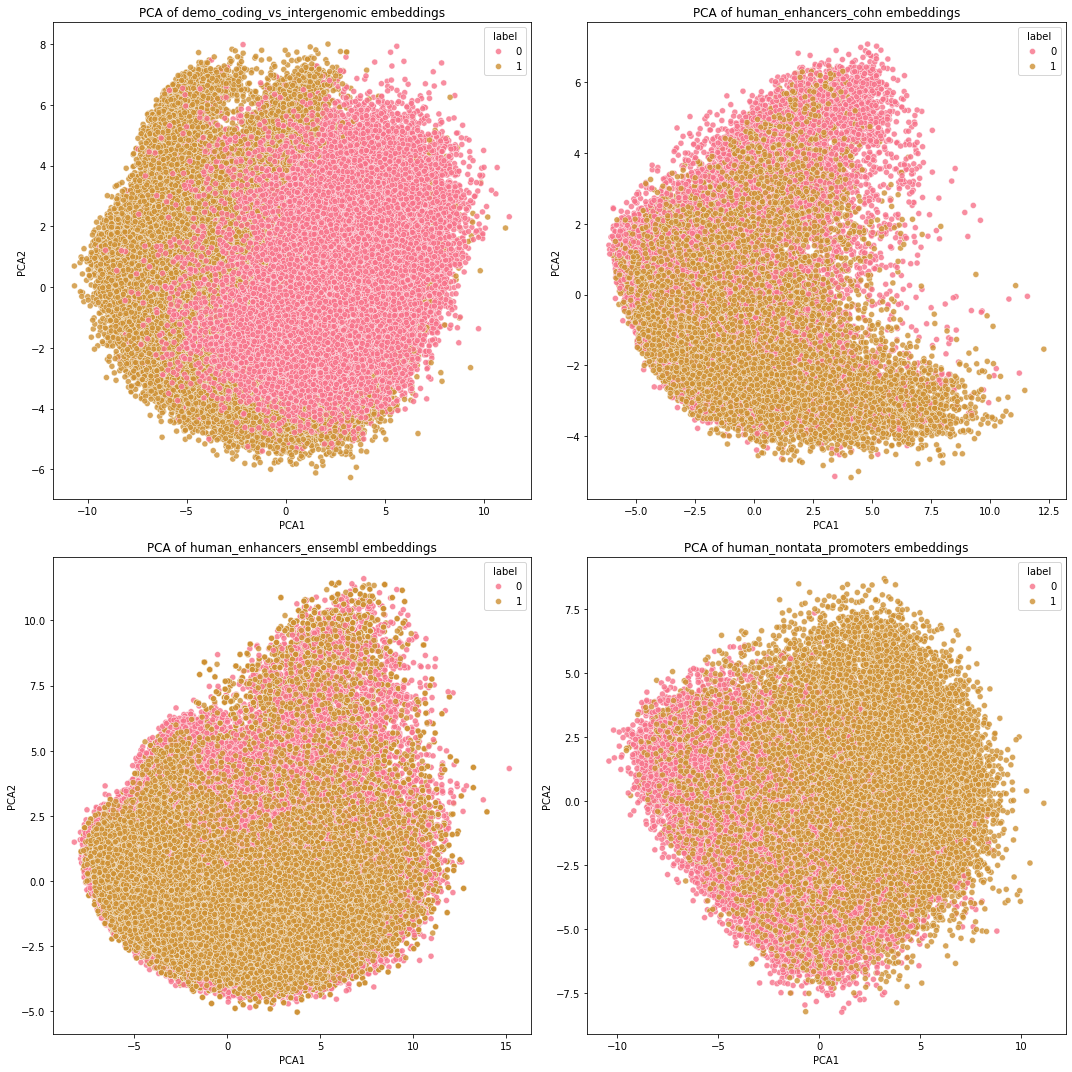

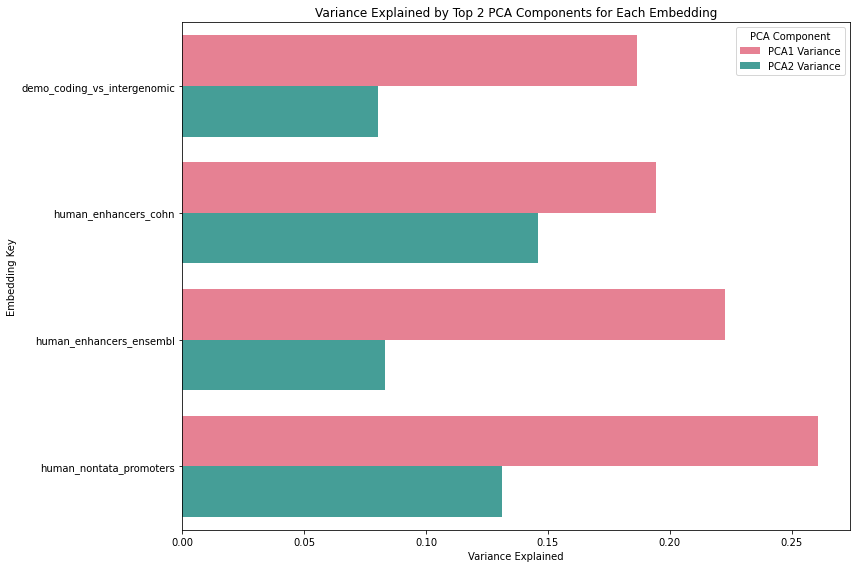

Total Variance Explained by Top 2 PCA Components:
                           Key  Total Variance (Top 2 PCA)
0  demo_coding_vs_intergenomic                    0.266782
1         human_enhancers_cohn                    0.340224
2      human_enhancers_ensembl                    0.305631
3      human_nontata_promoters                    0.391780


In [12]:
%matplotlib inline


# Function to combine train and test matrices
def combine_train_test(train_file, test_file):
    train_matrix = matrices[train_file]
    test_matrix = matrices[test_file]
    combined_matrix = np.vstack((train_matrix, test_matrix))
    return combined_matrix

# Combine the matrices for each sequence type
combined_matrices = {}
combined_matrices['demo_coding_vs_intergenomic'] = combine_train_test(
    'train_demo_coding_vs_intergenomic_seqs_NT_Embeddings.npy', 
    'test_demo_coding_vs_intergenomic_seqs_NT_Embeddings.npy'
)
combined_matrices['human_enhancers_cohn'] = combine_train_test(
    'train_human_enhancers_cohn_NT_Embeddings.npy', 
    'test_human_enhancers_cohn_NT_Embeddings.npy'
)
combined_matrices['human_enhancers_ensembl'] = combine_train_test(
    'train_human_enhancers_ensembl_NT_Embeddings.npy', 
    'test_human_enhancers_ensembl_NT_Embeddings.npy'
)

combined_matrices['human_nontata_promoters'] = combine_train_test(
    'train_human_nontata_promoters_NT_Embeddings.npy', 
    'test_human_nontata_promoters_NT_Embeddings.npy'
)


# Paths to CSV files
base_path = '/mnt/vstor/SOM_EPBI_XXZ10/raghav/Unsupervised_Evaluation_LLM/PaperWork/datasets/'

csv_files = {
    'demo_coding_vs_intergenomic': ['train_demo_coding_vs_intergenomic_seqs.csv', 'test_demo_coding_vs_intergenomic_seqs.csv'],
    'human_enhancers_cohn': ['train_human_enhancers_cohn.csv', 'test_human_enhancers_cohn.csv'],
    'human_enhancers_ensembl': ['train_human_enhancers_ensembl.csv', 'test_human_enhancers_ensembl.csv'],
    'human_nontata_promoters': ['train_human_nontata_promoters.csv', 'test_human_nontata_promoters.csv'],
}

# Dictionary to store combined DataFrames
combined_dfs = {}

# Function to combine train and test DataFrames
def combine_train_test(train_file, test_file):
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    combined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return combined_df

# Combine the DataFrames for each sequence type
for key, (train_file, test_file) in csv_files.items():
    train_path = os.path.join(base_path, train_file)
    test_path = os.path.join(base_path, test_file)
    combined_dfs[key] = combine_train_test(train_path, test_path)



# Set the color palette for all plots
sns.set_palette(sns.color_palette("husl", 8))

# Assuming `combined_matrices` and `combined_dfs` are predefined

# Create a 2-column, 2-row grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()

for i, (key, embeddings) in enumerate(combined_matrices.items()):
    # Check if the dimensions of the embeddings and the labels match
    print(f"{key} - Embeddings shape: {embeddings.shape}, Labels length: {len(combined_dfs[key])}")

    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    embeddings = np.asarray(embeddings)
    pca_result = pca.fit_transform(embeddings)
    
    # Create a DataFrame for the PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
    
    # Merge with the labels
    combined_df = combined_dfs[key]
    pca_df['label'] = combined_df['label']
    
    # Create a scatter plot on the respective axis
    sns.scatterplot(
        x='PCA1', y='PCA2',
        hue='label',
        data=pca_df,
        legend="full",
        alpha=0.8,
        ax=axes[i]
    )
    
    axes[i].set_title(f'PCA of {key} embeddings')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')

# Adjust layout
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_scatter_plots_NT.pdf')
plt.show()

# Prepare data for bar plot
variance_data = []

for key, embeddings in combined_matrices.items():
    # Check if the dimensions of the embeddings and the labels match
    if embeddings.shape[0] != len(combined_dfs[key]):
        print(f"Mismatch in number of embeddings and labels for {key}")
        continue
    
    # Perform PCA
    pca = PCA(n_components=2)
    embeddings=np.asarray(embeddings)
    pca_result = pca.fit_transform(embeddings)
    
    # Calculate the variance explained by the top 2 PCA components
    explained_variance_ratio = pca.explained_variance_ratio_
    variance_data.append({
        'Key': key,
        'PCA1 Variance': explained_variance_ratio[0],
        'PCA2 Variance': explained_variance_ratio[1],
        'Total Variance (Top 2 PCA)': explained_variance_ratio[0] + explained_variance_ratio[1]
    })
    
# Convert to DataFrame
variance_df = pd.DataFrame(variance_data)

# Melt the DataFrame for easier plotting with seaborn
variance_melted = variance_df.melt(id_vars=['Key'], value_vars=['PCA1 Variance', 'PCA2 Variance'],
                                    var_name='PCA Component', value_name='Variance Explained')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Variance Explained', y='Key', hue='PCA Component', data=variance_melted, palette='husl')
plt.title('Variance Explained by Top 2 PCA Components for Each Embedding')
plt.xlabel('Variance Explained')
plt.ylabel('Embedding Key')
plt.legend(title='PCA Component')
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/PCA_variance_bar_plot_NT.pdf')
plt.show()

# Print the total variance explained by the top 2 components
print("Total Variance Explained by Top 2 PCA Components:")
print(variance_df[['Key', 'Total Variance (Top 2 PCA)']])


Processing demo_coding_vs_intergenomic...
Mean of demo_coding_vs_intergenomic correlation values: -0.0008
Standard Deviation of demo_coding_vs_intergenomic correlation values: 0.1933
Processing human_enhancers_cohn...
Mean of human_enhancers_cohn correlation values: -0.0007
Standard Deviation of human_enhancers_cohn correlation values: 0.2118
Processing human_enhancers_ensembl...
Mean of human_enhancers_ensembl correlation values: -0.0007
Standard Deviation of human_enhancers_ensembl correlation values: 0.2072
Processing human_nontata_promoters...
Mean of human_nontata_promoters correlation values: -0.0007
Standard Deviation of human_nontata_promoters correlation values: 0.2434


/tmp/job.1712284.hpc/ipykernel_56959/673043524.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)


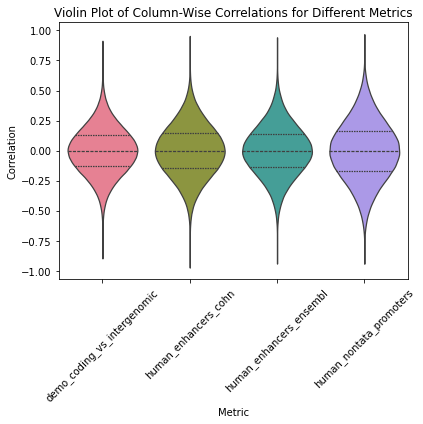

In [13]:
# Flatten the correlation matrices and organize into a DataFrame
data_for_violin_plot = []
for key, matrix in combined_matrices.items():
    print(f"Processing {key}...")
    correlation_matrix = calculate_column_wise_correlation(matrix)
    flattened_vector = flatten_correlation_matrix(correlation_matrix)
    
    # Calculate mean and standard deviation
    mean_value = np.mean(flattened_vector)
    std_dev_value = np.std(flattened_vector)
    
    # Print the mean and standard deviation
    print(f"Mean of {key} correlation values: {mean_value:.4f}")
    print(f"Standard Deviation of {key} correlation values: {std_dev_value:.4f}")
    
    # Append the correlation values to the list
    for value in flattened_vector:
        data_for_violin_plot.append({'Metric': key, 'Correlation': value})

# Convert list to DataFrame
df_for_violin_plot = pd.DataFrame(data_for_violin_plot)

# Define a color palette for the violin plot
# This example uses a color palette with a different color for each metric
palette = sns.color_palette("husl", len(df_for_violin_plot['Metric'].unique()))

# Create the violin plot
plt.figure(figsize=(6, 6))
sns.violinplot(x='Metric', y='Correlation', data=df_for_violin_plot, inner='quartile', palette=palette)
plt.title('Violin Plot of Column-Wise Correlations for Different Metrics')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('/home/rxa615/UnsupervisedEvaluation_PaperFigure/Result1/Correlation_Violen_plot_NT.pdf')
plt.show()